## MIA comparison between BN and CN (local IDM)

In [1]:
import random
import numpy as np
from pandas import testing as tm
import math
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.stats import norm

import pyagrum as gum
import pyagrum.lib.notebook as gnb

In [2]:
# Set seeds
random.seed(42)
gum.initRandom(seed=42)

In [3]:
# Init BN
bn=gum.fastBN("A[2]->B[3]<-C[2]")

# Plot BN
gnb.flow.row(bn, bn.cpt("A"), bn.cpt("B"), captions=["BN", "CPT (A)", "CPT (B|A)"])

In [4]:
# Set gpop, pool and rpop sample sizes
gpop_ss = 5000
ratio = 6

pool_ss = gpop_ss // ratio
rpop_ss = gpop_ss - pool_ss

assert(gpop_ss == pool_ss + rpop_ss)

In [5]:
# Generate data from BN
g = gum.BNDatabaseGenerator(bn)
g.drawSamples(gpop_ss)
g.setDiscretizedLabelModeRandom()

gpop = g.to_pandas()
pool_idx = np.random.choice(gpop_ss, replace=False, size=pool_ss)
pool = gpop.iloc[pool_idx]
rpop = gpop.iloc[~ gpop.index.isin(pool_idx)]

assert(gpop.shape[0]==gpop_ss)
assert(pool.shape[0]==pool_ss)
assert(rpop.shape[0]==rpop_ss)

In [6]:
# Add counts of events to BN
pop = pool
for node in bn.names():
    var = bn.variable(node)
    parents = bn.parents(node)
    parent_names = [bn.variable(p).name() for p in parents]

    shape = [bn.variable(p).domainSize() for p in parents] + [var.domainSize()]
    counts_array = np.zeros(shape, dtype=float)  # float, not int!

    for _, row in pop.iterrows():
        try:
            key = tuple([int(row[p]) for p in parent_names] + [int(row[node])])
            counts_array[key] += 1.0
        except KeyError:
            continue

    bn.cpt(node).fillWith(counts_array.flatten().tolist())

In [7]:
# Convert BN to CN
cn = gum.CredalNet(bn)

# IDM Learning ('s' must be an integer)
cn.idmLearning(s=2)

In [8]:
# Save BN min & max
cn.saveBNsMinMax("./bn_min.bif", "./bn_max.bif")

# Load BN min & max
bn_min = gum.loadBN("./bn_min.bif")
bn_max = gum.loadBN("./bn_max.bif")

In [ ]:
# Learn BNs with theta and theta_hat
theta_learner=gum.BNLearner(rpop)
theta_hat_learner=gum.BNLearner(pool)

bn_theta = theta_learner.learnParameters(bn.dag())
bn_theta_hat = theta_hat_learner.learnParameters(bn.dag())

In [10]:
# Plot
gnb.flow.row(bn, bn_theta.cpt("B"), bn_min.cpt("B"), bn_max.cpt("B"), 
             captions=["Graph", "Theta_B", "Theta_B min", "Theta_B max"])

In [11]:
# Create objects for inference
bn_theta_ie = gum.LazyPropagation(bn_theta)
bn_theta_hat_ie = gum.LazyPropagation(bn_theta_hat)

bn_min_ie = gum.LazyPropagation(bn_min)
bn_max_ie = gum.LazyPropagation(bn_max)

In [12]:
# Define the log-likelihood ratio L(x)
def L(x: dict):

    # Erase all the evidences and apply addEvidence(key,value) for every pairs in x
    bn_theta_ie.setEvidence(x)
    assert(bn_theta_ie.nbrHardEvidence() == len(bn.nodes()))
    bn_theta_hat_ie.setEvidence(x)
    assert(bn_theta_hat_ie.nbrHardEvidence() == len(bn.nodes()))

    # Compute P(x | BN)
    L_theta = bn_theta_ie.evidenceProbability()
    L_theta_hat = bn_theta_hat_ie.evidenceProbability()

    return math.log(L_theta / L_theta_hat)

In [13]:
# Define the log-likelihood ratio L_min(x)
def L_min(x: dict):

    # Erase all the evidences and apply addEvidence(key,value) for every pairs in x
    bn_theta_ie.setEvidence(x)
    assert(bn_theta_ie.nbrHardEvidence() == len(bn.nodes()))
    bn_max_ie.setEvidence(x)
    assert(bn_max_ie.nbrHardEvidence() == len(bn.nodes()))

    # Compute P(x | BN)
    L_theta = bn_theta_ie.evidenceProbability()
    L_theta_hat = bn_max_ie.evidenceProbability()

    return math.log(L_theta / L_theta_hat)

In [14]:
# Define the log-likelihood ratio L_max(x)
def L_max(x: dict):

    # Erase all the evidences and apply addEvidence(key,value) for every pairs in x
    bn_theta_ie.setEvidence(x)
    assert(bn_theta_ie.nbrHardEvidence() == len(bn.nodes()))
    bn_min_ie.setEvidence(x)
    assert(bn_min_ie.nbrHardEvidence() == len(bn.nodes()))

    # Compute P(x | BN)
    L_theta = bn_theta_ie.evidenceProbability()
    L_theta_hat = bn_min_ie.evidenceProbability()

    return math.log(L_theta / L_theta_hat)

In [15]:
# Example
x = rpop.iloc[4].to_dict()

l = L(x)
l_min = L_min(x)
l_max = L_max(x)

print(f"L(x) = {l}")
print(f"L_min(x) = {l_min}")
print(f"L_max(x) = {l_max}")

assert(l_min <= l)
assert(l <= l_max)

L(x) = 0.3073613802430492
L_min(x) = 0.006397219450241246
L_max(x) = 0.4792106851499702


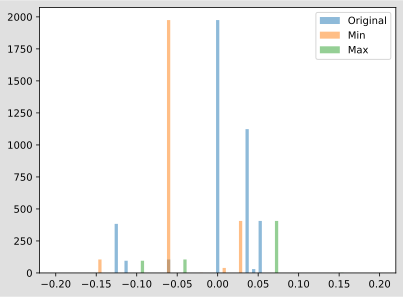

In [16]:
# Compute the distribution of L(x) under H_0, empirically on the reference population
L_im = rpop.apply(lambda x: L(x.to_dict()), axis=1)

# Compute the min-max distributions of L(x) under H_0, empirically on the reference population
L_im_min = rpop.apply(lambda x: L_min(x.to_dict()), axis=1)
L_im_max = rpop.apply(lambda x: L_max(x.to_dict()), axis=1)

# Plot the empirical distributions of L(x) under H_0
bins = np.linspace(-0.2, 0.2, 100)
plt.hist(L_im, bins, alpha=0.5, label='Original')
plt.hist(L_im_min, bins, alpha=0.5, label='Min')
plt.hist(L_im_max, bins, alpha=0.5, label='Max')

plt.legend()

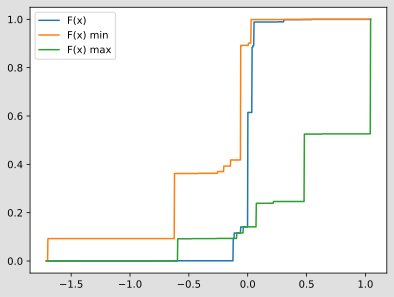

In [17]:
# Estimate the empirical CDF (ECDF) of L(x)
ecdf = ECDF(L_im)

# Estimate the min-max empirical CDFs (ECDF) of L(x)
ecdf_min = ECDF(L_im_min)
ecdf_max = ECDF(L_im_max)

# Plot the ECDFs
p_x = np.linspace(min(L_im_min), max(L_im_max), 1000)
p_y = ecdf(p_x)
p_y_min = ecdf_min(p_x)
p_y_max = ecdf_max(p_x)
plt.plot(p_x, p_y, label="F(x)")
plt.plot(p_x, p_y_min, label="F(x) min")
plt.plot(p_x, p_y_max, label="F(x) max")

plt.legend()

--------------------------------------------

In [18]:
# Define the test
def reject_H0(x: dict, t: float, w: str = None) -> bool:
    if w == "min":
        return L_min(x) < t
    elif w == "max":
        return L_max(x) < t
    else:
        return L(x) < t

In [19]:
# Example
x = pool.iloc[4].to_dict()

alpha = 0.05
threshold = np.quantile(L_im, alpha).item()

print(f"Original: {reject_H0(x, threshold)}")
print(f"Min: {reject_H0(x, threshold, 'min')}")
print(f"Max: {reject_H0(x, threshold, 'max')}")

Original: False
Min: False
Max: False


In [20]:
# Perform membership inference on whole general population
gpop["in-pool"] = False
gpop.loc[pool_idx, "in-pool"] = True
assert(sum(gpop["in-pool"] == True) == pool_ss)

gpop["in-pool-pred-min"] = gpop[[*bn.names()]].apply(lambda x: reject_H0(x.to_dict(), threshold, 'min'), axis=1)
gpop["in-pool-pred-max"] = gpop[[*bn.names()]].apply(lambda x: reject_H0(x.to_dict(), threshold, 'max'), axis=1)

# Get consistent results, i.e. where pred-min == pred-max
cons = gpop[gpop["in-pool-pred-min"] == gpop["in-pool-pred-max"]].index
gpop["in-pool-pred"] = gpop["in-pool-pred-min"]
gpop_cons = gpop.iloc[cons]

tm.assert_series_equal(gpop_cons["in-pool-pred-min"], gpop_cons["in-pool-pred-max"], check_names=False)

gpop_cons.head()

,A,B,C,in-pool,in-pool-pred-min,in-pool-pred-max,in-pool-pred
0,1,2,0,True,False,False,False
1,1,1,0,False,True,True,True
2,1,1,0,True,True,True,True
3,1,1,0,False,True,True,True
4,1,2,0,False,False,False,False


In [21]:
# Confusion matrix
'''
C_{ij} means i, predicted as j

Predicted
 -----------
| TP  |  FN |
|-----------|
| FP  |  TN |
 -----------
 
'''

cm_count = confusion_matrix(gpop_cons["in-pool"], gpop_cons["in-pool-pred"], labels=[True, False])

assert(len(cons) == gpop_cons.shape[0])
assert(len(cons) == int(np.sum(cm_count)))

print(f"Count CM:\n {cm_count}\n") 

# Normalize CM based on gpop_ss
cm = cm_count / gpop_ss
tpr = cm[0,0]
fpr = cm[1,0]

print(f"Rate CM:\n {cm}") 


Count CM:
 [[  89  479]
 [ 389 2425]]

Rate CM:
 [[0.0178 0.0958]
 [0.0778 0.485 ]]


In [22]:
# Exp
t=threshold
y_pred_min = gpop[[*bn.names()]].apply(lambda x: reject_H0(x.to_dict(), t, "min"), axis=1)
y_pred_max = gpop[[*bn.names()]].apply(lambda x: reject_H0(x.to_dict(), t, "max"), axis=1)
cons = y_pred_min == y_pred_max
cm_count = confusion_matrix(gpop[cons]["in-pool"], y_pred_min[cons], labels=[True, False])
cm = cm_count / gpop_ss

In [23]:
# Set threshold range
t_range = np.arange(-1e1, 1e1, 0.05)

################################################

# Init the error and power vectors (BN)
error = []
power_bn = []

# For each threshold ...
for t in t_range:

    # Store the related error
    error = error + [ecdf(t)]

    # Perform LR test on whole population
    y_pred = gpop[[*bn.names()]].apply(lambda x: reject_H0(x.to_dict(), t), axis=1)

    # Compute and store power (tpr)
    cm = confusion_matrix(gpop["in-pool"], y_pred, labels=[True, False], normalize='all')
    tpr = cm[0,0]
    power_bn = power_bn + [tpr]

################################################

# Init the power vector (CN) (error is the same as BN)
power_cn = []

# For each threshold ...
for t in t_range:

    # Perform min-max LR test on whole population
    y_pred_min = gpop[[*bn.names()]].apply(lambda x: reject_H0(x.to_dict(), t, "min"), axis=1)
    y_pred_max = gpop[[*bn.names()]].apply(lambda x: reject_H0(x.to_dict(), t, "max"), axis=1)
    cons = y_pred_min == y_pred_max

    # Compute and store power (tpr)
    cm_count = confusion_matrix(gpop[cons]["in-pool"], y_pred_min[cons], labels=[True, False])
    tpr = cm_count[0,0] / gpop_ss
    power_cn = power_cn + [tpr]    


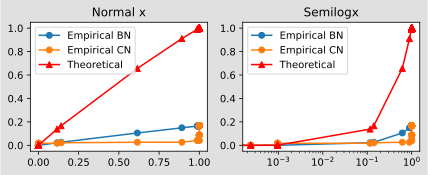

In [24]:
# Plot error vs power (empirical BN)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7, 7/3))
ax1.plot(error, power_bn, "-o", label = 'Empirical BN')
ax2.semilogx(error, power_bn, "-o", label = 'Empirical BN')

# Plot error vs power (empirical CN)
ax1.plot(error, power_cn, "-o", label = 'Empirical CN')
ax2.semilogx(error, power_cn, "-o", label = 'Empirical CN')

# Compute theoretical bound
bound = math.sqrt(bn.dim()/pool_ss)

# Find power (beta) for any error (alpha) given theoretical bound
z_alpha = [norm.ppf(1 - i).item() for i in error]
z_one_minus_beta = [bound - i for i in z_alpha]
beta = [norm.cdf(i).item() for i in z_one_minus_beta]

# Plot error vs power (theoretical)
ax1.plot(error, beta, "r-^", label = 'Theoretical')
ax2.semilogx(error, beta, "r-^", label = 'Theoretical')

# Plot info
ax1.set(title='Normal x')
ax2.set(title='Semilogx')

ax1.legend()
ax2.legend()
